# Parsing Data Into Standard Formats

> Note: this notebook uses [`scikit-learn`](https://scikit-learn.org/). Install it into your virtual environment using `pip install scikit-learn`.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

from utils.u02_parsing import get_header, get_data, measurement_type, simplify_magnetic_df

# matplotlib "inline" magic command
# allows plots to be displayed in the notebook
%matplotlib inline

The functions answering the exercises from the Reading Files into DataFrames tutorial are available in [utils/u02_parsing.py](utils/u02_parsing.py). In this tutorial we'll be adding ZFCFC data to our list of files to parse. 

### A quick aside on a bug

In the course of making this tutorial I found some odd behavior with some .dat files that affected the `get_data()` function. Specifically, the `pd.read_csv()` function gave inconsistent behavior regarding the `sep='\t'` argument. Example below:

In [2]:
def old_get_data(file_path: str | Path) -> pd.DataFrame:
    file_path = Path(file_path)
    skip_rows = len(get_header(file_path))
    df = pd.read_csv(file_path, sep="\t", skiprows=skip_rows)
    return df

In [3]:
old_mvsh1 = old_get_data("data/mvsh1.dat")
old_mvsh1.head()

,Comment,Time Stamp (sec),Temperature (K),Magnetic Field (Oe),Moment (emu),M. Std. Err. (emu),Transport Action,Averaging Time (sec),Frequency (Hz),Peak Amplitude (mm),...,Map 07,Map 08,Map 09,Map 10,Map 11,Map 12,Map 13,Map 14,Map 15,Map 16
0,NaN,3803627317,2.000165,70000.37500,0.736924,0.000996,1,1,13.006381,0.999015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,3803627320,2.000241,69995.39844,0.736522,0.001055,1,1,13.006381,0.999028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3803627325,1.999892,69746.85938,0.737400,0.001470,1,1,13.006381,0.999024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,3803627334,2.000141,69286.15625,0.736039,0.000992,1,1,13.006381,0.999066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,3803627335,1.999827,69246.48438,0.737444,0.001020,1,1,13.006381,0.999066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
old_zfcfc1 = old_get_data("data/zfcfc1.dat")
old_zfcfc1.head()

,"Comment,Time Stamp (sec),Temperature (K),Magnetic Field (Oe),Moment (emu),M. Std. Err. (emu),Transport Action,Averaging Time (sec),Frequency (Hz),Peak Amplitude (mm),Center Position (mm),Lockin Signal' (V),Lockin Signal (V),Range,M. Quad. Signal (emu),AC Moment (emu),AC M. Std Err. (emu),AC Phase (deg),AC Phase Std. Err. (deg),AC Susceptibility (emu/Oe),AC Suscept. Std Err. (emu/Oe),AC X' (emu/Oe),AC X' Std Err. (emu/Oe),AC X'' (emu/Oe),AC X'' Std Err. (emu/Oe),AC Drive (Oe),AC Frequency (Hz),AC Averaging Time (sec),AC Cycles,AC Range,AC Measure Type,AC Signal' (V),AC Signal'' (V),AC Trim Coil Ratio,AC Trim Coil Phase,Min. Temperature (K),Max. Temperature (K),Min. Field (Oe),Max. Field (Oe),Mass (grams),Motor Lag (deg),Pressure (Torr),Measure Count,Measurement Number,SQUID Status (code),Motor Status (code),Measure Status (code),Motor Current (amps),Motor Temp. (C),Temp. Status (code),Field Status (code),Chamber Status (code),Chamber Temp (K),Redirection State,Evercool Status,Average Temp (K),Rotation Angle (deg),Rotator state,DC Moment Fixed Ctr (emu),DC Moment Err Fixed Ctr (emu),DC Moment Free Ctr (emu),DC Moment Err Free Ctr (emu),DC Fixed Fit,DC Free Fit,DC Calculated Center (mm),DC Calculated Center Err (mm),DC Scan Length (mm),DC Scan Time (s),DC Number of Points,DC Squid Drift,DC Min V (V),DC Max V (V),DC Scans per Measure,Map 01,Map 02,Map 03,Map 04,Map 05,Map 06,Map 07,Map 08,Map 09,Map 10,Map 11,Map 12,Map 13,Map 14,Map 15,Map 16"
0,",3841156886.68016,5.00255632400513,100.0726470..."
1,",3841156903.92312,5.53037929534912,100.0726470..."
2,",3841156913.8568,6.27978539466858,100.07264709..."
3,",3841156923.64033,7.01898741722107,100.0726470..."
4,",3841156933.37227,7.76241564750671,100.0726470..."


Thus, the `get_data()` function found in [utils/u02_parsing.py](utils/u02_parsing.py) has been modified. When incorrectly parsed with `sep='\t'`, the returned DatFrame has only one column. These .dat files can be correctly parsed by letting `pd.read_csv()` infer the separator (which, strangely, does not work for some .dat files which require the `sep='\t'` argument).

The new `get_data()` function is as follows:

```python
def get_data(file_path: str | Path) -> pd.DataFrame:
    file_path = Path(file_path)
    skip_rows = len(get_header(file_path))
    df = pd.read_csv(file_path, sep="\t", skiprows=skip_rows)
    # for unknown reasons, some .dat files parse incorrectly with sep="\t"
    # the incorrectly parsed df has only one column
    if df.shape[1] == 1:
        df = pd.read_csv(file_path, skiprows=skip_rows)
    return df
```

### Now back to your regularly scheduled content

At the top of the notebook we've imported a handful of functions which help us parse .dat files:

```python
from utils.u02_parsing import get_header, get_data, measurement_type, simplify_magnetic_df
```

Let's combine these into a single function `magnetic_df()` which takes a file path and returns a DataFrame with the magnetic data:

In [5]:
def magnetic_df(file_path: str | Path) -> pd.DataFrame:
    df = get_data(file_path)
    return simplify_magnetic_df(df)

Now we'll read in some data files.

In [6]:
mvsh1 = magnetic_df("data/mvsh1.dat")
mvsh2 = magnetic_df("data/mvsh2.dat")
mvsh3 = magnetic_df("data/mvsh3.dat")
zfcfc1 = magnetic_df("data/zfcfc1.dat")
zfcfc2 = magnetic_df("data/zfcfc2.dat")
zfcfc3 = magnetic_df("data/zfcfc3.dat")

Let's take a look at the data in these files. Plotting and the `matplotlib` library will be the topic of a future tutorial. Here's something to get you started.

Side note: [here's an article describing the `enumerate` function](https://realpython.com/python-enumerate/). In short, it's a way to iterate over a list while also keeping track of the index of the current item in the list.

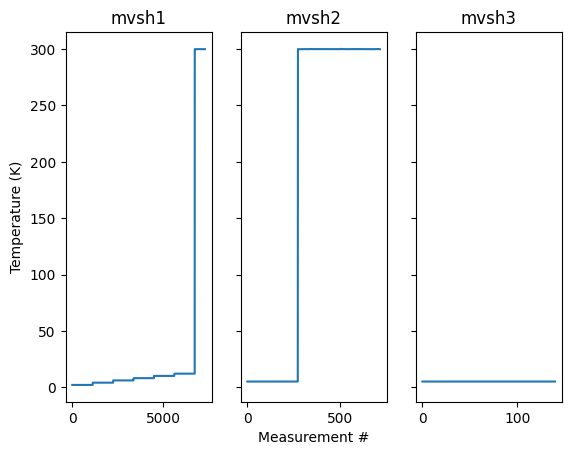

In [7]:
fig, axs = plt.subplots(1, 3, sharey=True)
for i, mvsh in enumerate([mvsh1, mvsh2, mvsh3]):
    axs[i].plot(mvsh.index, mvsh['temp'])
    axs[i].set_title(f"mvsh{i+1}")
axs[0].set_ylabel("Temperature (K)")
axs[1].set_xlabel("Measurement #")
plt.show()

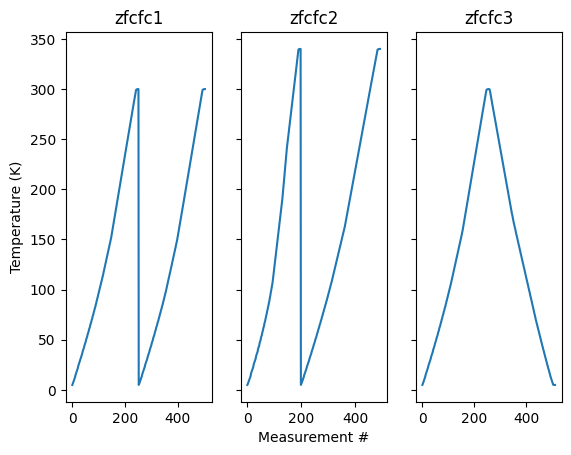

In [8]:
fig, axs = plt.subplots(1, 3, sharey=True)
for i, zfcfc in enumerate([zfcfc1, zfcfc2, zfcfc3]):
    axs[i].plot(zfcfc.index, zfcfc['temp'])
    axs[i].set_title(f"zfcfc{i+1}")
axs[0].set_ylabel("Temperature (K)")
axs[1].set_xlabel("Measurement #")
plt.show()

When we get to data modeling, we'll want easy access to individual experiments. For example, we might want to look at M vs H data at 5 K for many samples, or we might want to look only at FC data at 100 Oe for many samples. Utlitmately we'll have to combine our knowledge of the potential experiments found in a .dat file with a combination of some parsing algorithms to figure out how to extract the data we want.

For the two separate problems (M vs H and ZFCFC data) the way I've plotted the data illustrates what our algorithms will be searching for. 
- In the case of M vs H data, the transition between different M vs H experiments within a single .dat file will be marked by a sudden change in the temperature. 
- In the case of ZFCFC data, the transition from ZFC to FC data will be marked by an interruption in otherwise monotonically increasing/decreasing temperature.

We won't be able to automatically parse everything. We'll have to set some rules that users follow when creating .dat files. For example, users probably shouldn't include both an M vs H measurement in the same file as a ZFCFC measurement. We'll write some rules in a later tutorial.

### M vs H parsing

Let's start by trying to separate `mvsh1` into a list of DataFrames where each DataFrame is a single M vs H experiment.

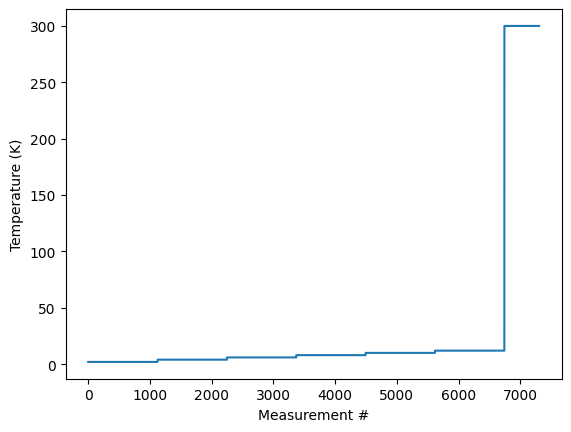

In [9]:
fig, ax = plt.subplots()
ax.plot(mvsh1.index, mvsh1['temp'])
ax.set_xlabel("Measurement #")
ax.set_ylabel("Temperature (K)")
plt.show()

Unfortunately we can't just pick out the unique temperature values, because temperature fluctuations between data points mean that basically every measurement will be at a unique temperature.

In [10]:
temps = mvsh1['temp'].unique()
temps

array([  2.00016522,   2.00024128,   1.99989176, ..., 299.9992676 ,
       299.9988098 , 299.9994507 ])

In [11]:
len(temps)

3619

The user clearly didn't intend to make measurements at 3619 different temperatures. We can see that the temperature is changing in a stepwise fashion. Let's try to find the stepwise changes in temperature and use those to separate the data into individual experiments.

There are several ways we can find the different sections of the data corresponding to each nominal temperature. One way would be to round the temperature values to the nearest integer (or half integer). The following examples use [the `pandas` `apply()` function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) with a [lambda function](https://realpython.com/python-lambda/) to round the temperature values to the nearest quarter integer. The nearest quarter integer is necesarry if we want to be able to differentiate between nominal temperatures separated by 0.5 K.

In [12]:
mvsh1['temp'].apply(lambda x: round(x/0.25)*0.25).unique()

array([  2.,   4.,   6.,   8.,  10.,  12., 300.])

In [13]:
mvsh2['temp'].apply(lambda x: round(x/0.25)*0.25).unique()

array([  5.  , 300.  , 299.75, 300.25])

As is shown with the `mvsh2` data, simply rounding to a set level of precision won't work, as the temperature of the magnetometer sometimes has greater variance at higher temperatures.

Knowing this, we can make a slightly more sophisticated rounding function, `round_temperature()`, which rounds temperatures based on the magnitude of the temperature value.

### Excercise 2.1

Write a function `round_temperature()` which takes a value `x` and rounds it to the nearest
- 0.25 K if `x` is less than 10 K
- 0.5 K if 10 < `x` < 50 K
- 1 K if `x` > 50 K.

In [14]:
def round_temperature(x):
    if x < 10:
        return round(x / 0.25) * 0.25
    elif x < 50:
        return round(x / 0.5) * 0.5
    else:
        return round(x)

In [15]:
assert round_temperature(2.45) == 2.5
assert round_temperature(8.70) == 8.75
assert round_temperature(11.3) == 11.5
assert round_temperature(299.7) == 300.0

### Exercise 2.2

Write a function `simple_find_unique_temperatures()` which takes a `pandas` `Series` (a single column of a `DataFrame`) and returns a list of unique temperatures within the data. Use the `round_temperature()` function you wrote in Exercise 2.1 to round the temperature values.

In [16]:
def simple_find_unique_temperatures(data: pd.Series) -> list[float]:
    return list(data.apply(round_temperature).unique())

In [17]:
assert simple_find_unique_temperatures(mvsh1['temp']) == [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 300.0]
assert simple_find_unique_temperatures(mvsh2['temp']) == [5.0, 300.0]

While the simple methods above have worked so far in `magnetopy`, `multi_cauchy`, and other projects, there are probably more robust alorithms we could use. [Clustering algorithms](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py) are a good place to start. [Here's a great video explaining DBSCAN](https://youtu.be/RDZUdRSDOok), which we'll be using next. 

[`DBSCAN` is in `scikit-learn`.](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) Before using it, we'll want to normalize our data. We can do this using the [`StandardScaler` class in `scikit-learn`.](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) `StandardScaler` will subtract the mean of each column and divide by the standard deviation of each column (or `Series`, in our case); the resulting data has a mean of 0 and standard deviation of 1. This is useful to do before clustering because it will make the data more amenable to clustering algorithms.

Spend some time with the following functions to understand how they work. You can go through each function line by line in a separate cell and print out the results of each step to see what's happening.

In [18]:
def label_clusters(vals: pd.Series, eps: float = 0.01, min_samples: int = 10) -> np.ndarray:
    reshaped_vals = vals.values.reshape(-1, 1)
    scaler = StandardScaler()
    reshaped_normalized_vals = scaler.fit_transform(reshaped_vals)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(reshaped_normalized_vals)
    return cluster_labels

def unique_values(
    x: pd.Series, eps: float = 0.01, min_samples: int = 10
) -> list[float]:
    cluster_labels = label_clusters(x, eps=eps, min_samples=min_samples)
    unique_values = []
    for i in np.unique(cluster_labels):
        # average the values in each cluster
        unique_val = np.mean(x[cluster_labels == i])
        unique_val = round(unique_val, 1)
        unique_values.append(unique_val)
    return unique_values

Let's confirm the same behavior as with our simple methods above.

In [19]:
unique_values(mvsh1['temp'])

[2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 300.0]

In [20]:
unique_values(mvsh2['temp'])

[5.0, 300.0]

In [21]:
unique_values(mvsh3['temp'])

[5.0]

We can also replot the M vs H data to see how the clustering algorithm has separated the data.

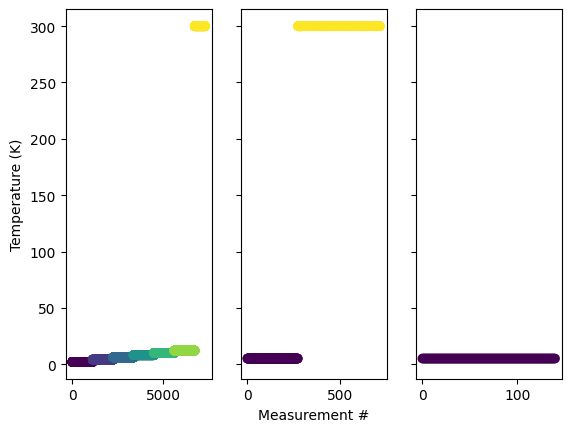

In [22]:
fig, axs = plt.subplots(1, 3, sharey=True)
for i, mvshX in enumerate([mvsh1, mvsh2, mvsh3]):
    mvsh = mvshX.copy()
    mvsh['cluster'] = label_clusters(mvsh['temp'])
    axs[i].scatter(mvsh.index, mvsh['temp'], c=mvsh['cluster'])
axs[0].set_ylabel("Temperature (K)")
axs[1].set_xlabel("Measurement #")
plt.show()

### Exercise 2.3

Write a function `mvsh()` that takes in a magnetic dataframe and returns a dictionary of DataFrames, where the keys are the nominal temperatures of the measurements and the values are the DataFrames containing the data for each measurement.

In [23]:
def mvsh(file_df: pd.DataFrame) -> dict[float, pd.DataFrame]:
    df = file_df.copy()
    df['cluster'] = label_clusters(df['temp'])
    dfs: dict[float, pd.DataFrame] = {}
    for temp, cluster in zip(unique_values(df['temp']), df['cluster'].unique()):
        dfs[temp] = df[df['cluster'] == cluster]
    return dfs

In [24]:
assert list(mvsh(mvsh1).keys()) == [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 300.0]
assert list(mvsh(mvsh2).keys()) == [5.0, 300.0]
assert list(mvsh(mvsh3).keys()) == [5.0]
assert len(mvsh(mvsh1)[2.0]) == len(mvsh(mvsh1)[2]) == 1124
assert len(mvsh(mvsh1)[300]) == 563
assert len(mvsh(mvsh2)[300]) == 445
assert len(mvsh(mvsh3)[5]) == 141

### ZFCFC parsing

Let's turn our attention back to ZFCFC data. Our eventual goal is to write a function which can give us a dictionary of DataFrames where the keys are "zfc" and "fc" and the values are the DataFrames containing the data for each measurement.

Here's the data we're working with:

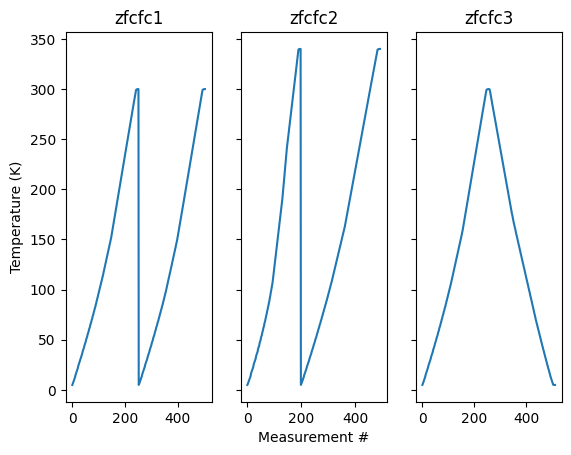

In [25]:
fig, axs = plt.subplots(1, 3, sharey=True)
for i, zfcfc in enumerate([zfcfc1, zfcfc2, zfcfc3]):
    axs[i].plot(zfcfc.index, zfcfc['temp'])
    axs[i].set_title(f"zfcfc{i+1}")
axs[0].set_ylabel("Temperature (K)")
axs[1].set_xlabel("Measurement #")
plt.show()

Separating ZFC and FC from within a ZFCFC file requires finding the turnaround point. There are two cases we'll consider:
1. The ZFC is collected first with monotonic temperature increase, temperature is reset to the starting temperature, and the FC is collected with monotonic temperature increase.
2. The ZFC is collected first with monotonic temperature increase, then the FC is collected with monotonic temperature decrease.

The `.diff()` method will help us easily see what's going on.

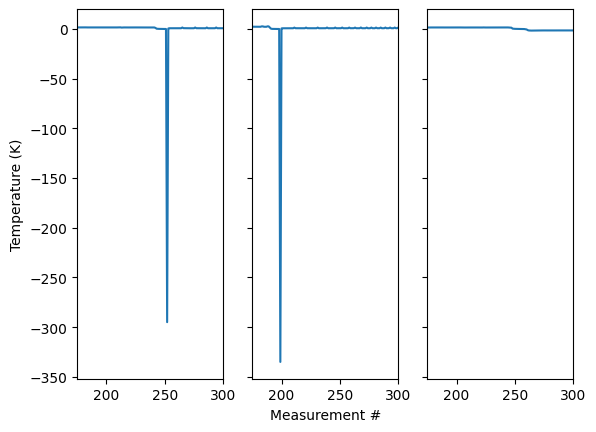

In [26]:
fig, axs = plt.subplots(1, 3, sharey=True)
for i, zfcfc in enumerate([zfcfc1, zfcfc2, zfcfc3]):
    zfcfc['diff'] = zfcfc['temp'].diff()
    zfcfc['diff'].iloc[0] = zfcfc['diff'].iloc[1]
    axs[i].plot(zfcfc.index, zfcfc['diff'])
    axs[i].set_xlim(175, 300)
axs[0].set_ylabel("Temperature (K)")
axs[1].set_xlabel("Measurement #")
plt.show()

Case #1 is easy to identify -- there will be one value in the `diff` column which is much larger than the others.

### Exercise 2.4

Write a function `find_outlier_indices()` which takes a `pandas` `Series` and an optional `threshold` argument (default value of 3) and returns a list of indices where the values are greater than `threshold` standard deviations from the mean. This is referred to as the [z-score or standard score](https://en.wikipedia.org/wiki/Standard_score). It's [available in `scipy`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html) but write it yourself using `pandas` and/or `numpy`.

In [27]:
def find_outlier_indices(x: pd.Series, threshold: float = 3) -> list[int]:
    z_scores = (x - x.mean()) / x.std()
    outliers = z_scores.abs() > threshold
    return list(outliers[outliers].index)

In [28]:
assert find_outlier_indices(zfcfc1['temp'].diff()) == [252]
assert find_outlier_indices(zfcfc2['temp'].diff()) == [199]
assert find_outlier_indices(zfcfc3['temp'].diff()) == []

Case #2 requires finding the point at which the difference in temperature between data points is closest to zero. Note that the end of both the ZFC and FC measurements will have temperature profiles which slowly approach the final temperature. We'll assume that there's only one ZFCFC measurement per file (as in, one field per file), so the turnaround point will be somewhere in the middle.

Text(0, 0.5, 'Temperature Difference (K)')

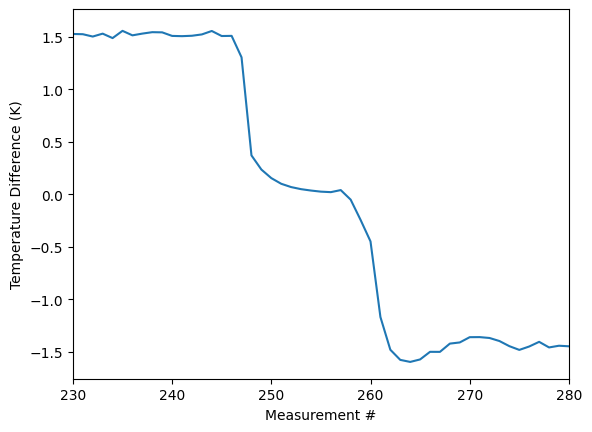

In [29]:
fig, ax = plt.subplots()
ax.plot(zfcfc3.index, zfcfc3['temp'].diff())
ax.set_xlim(230, 280) # comment out this line to see all of the data
ax.set_xlabel("Measurement #")
ax.set_ylabel("Temperature Difference (K)")

### Exercise 2.5

Write a function `find_turnaround_point()` which takes a magnetic dataframe (of the sort returned by `magnetic_df()`) containing data from a ZFCFC file and returns the index of the dataframe representing the first data point of the FC measurement. This should work for both cases #1 and #2.

In [30]:
def find_temp_turnaround_point(df: pd.DataFrame) -> int:
    outlier_indices = find_outlier_indices(df['temp'].diff())
    if len(outlier_indices) == 0:
        # zfc temp increases, fc temp decreases
        zero_point = abs(df['temp'].iloc[20:-20].diff()).idxmin()
        return zero_point
    else:
        # zfc temp increases, reset temp, fc temp increases
        return outlier_indices[0]

In [31]:
assert find_temp_turnaround_point(zfcfc1) == 252
assert find_temp_turnaround_point(zfcfc2) == 199
assert find_temp_turnaround_point(zfcfc3) == 256

### Exercise 2.6

Finally, write a function `zfcfc()` which takes a magnetic data frame and returns a dictionary of DataFrames, where the keys are "zfc" and "fc" and the values are the DataFrames containing the data for each measurement.

In [32]:
def zfcfc(file_df: pd.DataFrame) -> dict[str, pd.DataFrame]:
    df = file_df.copy()
    turnaround_point = find_temp_turnaround_point(df)
    zfc = df.iloc[:turnaround_point].reset_index(drop=True)
    fc = df.iloc[turnaround_point:].reset_index(drop=True)
    return {'zfc': zfc, 'fc': fc}

In [33]:
assert len(zfcfc(zfcfc1)['zfc']) == 252
assert len(zfcfc(zfcfc1)['fc']) == 252
assert len(zfcfc(zfcfc2)['zfc']) == 199
assert len(zfcfc(zfcfc2)['fc']) == 295
assert len(zfcfc(zfcfc3)['zfc']) == 256
assert len(zfcfc(zfcfc3)['fc']) == 257

### Exercise 2.7

Write a function `experiment_type()` which takes a magnetic data frame and returns a string indicating the type of measurement. The string should be one of "mvsh", "zfcfc". Based on the assumptions we've made about how people are creating .dat files, we'll assume that if it's a dc measurement (VSM or DC scan) and there's only one field, it's a ZFCFC experiment. Otherwise, it's an M vs H experiment.

In [34]:
def experiment_type(df: pd.DataFrame) -> str:
    if len(df['field'].unique()) == 1:
        return 'zfcfc'
    else:
        return 'mvsh'

In [35]:
assert experiment_type(mvsh1) == 'mvsh'
assert experiment_type(mvsh2) == 'mvsh'
assert experiment_type(mvsh3) == 'mvsh'
assert experiment_type(zfcfc1) == 'zfcfc'
assert experiment_type(zfcfc2) == 'zfcfc'
assert experiment_type(zfcfc3) == 'zfcfc'

## Comments in the Data Files Remove Ambguity

What we are building so far is a way to algorithmically look at a .dat file and infer what the user intended to measure. This will probably work most of the time, but as the number of experiments increases it will become increasingly difficult to make an inference about the user's intent. As a simple example, consider how we just separated M vs H measurements from ZFCFC measurements -- we had to rely on the fact that *typically* users only put one ZFCFC experiment (i.e., one field) in a .dat file. Similarly, we also have to use our domain knowledge to infer that a ZFCFC file first contains the ZFC, then the FC experiment. However, the .dat file itself contains no information on the field history -- all that we know from the .dat file is that all measurements occurred under some particular field. 

What would happen if a user performed two ZFCFC measurements and recorded the data in the same file? It certainly wouldn't be impossible to algorithmically determine what is happening, but the parsing functions quickly become very complicated. Or how would we infer data from experiments intended to look at reduced magnetization plots -- the data will look very similar to M vs H data, but the anlaysis we will want to do will be very different.

We can make our lives easier by being explicit about what is in our .dat files. Quantum Design's MultiVu sequence editor allows for comments to be placed in the .dat file. The comments are written as their own lines within the "[Data]" block of the .dat file.

The following .dat files are taken from a single sample and include measurements for ZFCFC experiments at 100 Oe and 1000 Oe and an M vs H measurement at a nominal temperature of 20 C. The philosophy guiding the file setup is that each file should contain only one type of experiment (ie. one ZFC experiment at a given field, or one FC experiment at a given field, or one M vs H experiment at a particular temperature). The appeal to this philosophy will become more clear in the next tutorial when we consider how to organize datasets.

In [36]:
fc4a = "data/fc4a.dat"
fc4b = "data/fc4b.dat"
zfc4a = "data/zfc4a.dat"
zfc4b = "data/zfc4b.dat"
zfcfc4 = "data/zfcfc4.dat"
mvsh4 = "data/mvsh4.dat"
dataset4 = "data/dataset4.dat"

In [37]:
data_with_comments = get_data(zfc4a)
data_with_comments.head(3)

,Comment,Time Stamp (sec),Temperature (K),Magnetic Field (Oe),Moment (emu),M. Std. Err. (emu),Transport Action,Averaging Time (sec),Frequency (Hz),Peak Amplitude (mm),...,Map 07,Map 08,Map 09,Map 10,Map 11,Map 12,Map 13,Map 14,Map 15,Map 16
0,"ZFC, 100",3.860753e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,3.860754e+09,4.999944,99.913757,0.000172,2.146960e-08,1.0,2.0,13.006381,5.002491,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3.860754e+09,5.073333,99.913757,0.000176,4.187254e-07,1.0,2.0,13.006381,4.996721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note that the comments exist on their own lines. In lines with actual data, the `Comment` column is `NaN`. We can use this to extract comments using the `dropna()` method. The following line looks at the "Comment" column and drops all rows that are `NaN`. The returned value is a `pandas` `Series` containing the comments.

In [38]:
comments = data_with_comments['Comment'].dropna()
comments

0    ZFC, 100
Name: Comment, dtype: object

The comments (as I have implemented them) are comma separated lists of keywords. For later parsing of the comments, it will be useful to have them as a list of strings.


In [39]:
comments_list = comments[0].split(',')
comments_list = [comment.strip() for comment in comments_list]
comments_list

['ZFC', '100']

The actual data can be recovered from the `data_with_comments` dataframe by dropping all rows that have `NaN` in, for example, the "Magnetic Field (Oe)" column.

In [40]:
data = data_with_comments.dropna(subset=['Magnetic Field (Oe)']).reset_index(drop=True)
data.head(3)

,Comment,Time Stamp (sec),Temperature (K),Magnetic Field (Oe),Moment (emu),M. Std. Err. (emu),Transport Action,Averaging Time (sec),Frequency (Hz),Peak Amplitude (mm),...,Map 07,Map 08,Map 09,Map 10,Map 11,Map 12,Map 13,Map 14,Map 15,Map 16
0,NaN,3.860754e+09,4.999944,99.913757,0.000172,2.146960e-08,1.0,2.0,13.006381,5.002491,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,3.860754e+09,5.073333,99.913757,0.000176,4.187254e-07,1.0,2.0,13.006381,4.996721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3.860754e+09,5.175865,99.913757,0.000177,2.141808e-08,1.0,2.0,13.006381,5.002613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exercise 2.8

The file "zfcfc4.dat" combines the data in "fc4a.dat", "zfc4a.dat", "fc4b.dat", and "zfc4b.dat" -- as if the user had performed two ZFCFC experiments (one at 100 Oe, one at 1000 Oe) and recorded the data in a single file. Write a function `get_comments()` which takes a file and returns an `OrderedDict` of comments, where the dictionary keys are the indices where the comments are found and the values are a list of strings of the comments at that index (you'll be able to use the `as_dict()` method of the `pandas` `Series` object to do this).

An `OrderedDict` is a class found in the `collections` module (which is part of the Python standard library). It's like a dictionary, but the order in which items are entered are remembered. This gives us access to a dictionary index (different than the index you'll be pulling from the .dat file), which will be useful for the next exercise.

Note: to make your answer match the one in the `assert` statements, you'll need to strip the leading white spaces from the comments. The comments as they're read in look like `"ZFC, 100"`, and your function should convert that to `["ZFC", "100"]`. You'll need the `strip()` and `split()` methods of the `str` class.

In [41]:
from collections import OrderedDict

def get_comments(file: str | Path) -> OrderedDict[str, list[str]]:
    data_with_comments = get_data(file)
    comments = data_with_comments['Comment'].dropna()
    comments = OrderedDict(comments)
    for key, value in comments.items():
        comments[key] = [comment.strip() for comment in value.split(',')]
    return comments

In [42]:
assert get_comments(mvsh4) == {0: ["MvsH", "293"]}
assert get_comments(zfc4a) == {0: ["ZFC", "100"]}
assert get_comments(zfcfc4) == {
    0: ["ZFC", "100"],
    1894: ["FC", "100"],
    3766: ["ZFC", "1000"],
    5659: ["FC", "1000"],
}

Here's how you can access both the `OrderedDict` indices and the indices retrieved from the .dat file:

In [43]:
zfcfc4_comments = get_comments(zfcfc4)
for i, (dat_idx, comment) in enumerate(zfcfc4_comments.items()):
    # the next element in the OrderedDict can be accessed by converting it to a list
    # and then indexing it with the current index + 1
    # watch out for the last element, which doesn't have a next element
    next_idx = list(zfcfc4_comments.keys())[i+1] if i+1 < len(zfcfc4_comments) else (len(get_data(zfcfc4)))
    print(f"{i}\t{comment}\t{dat_idx}\t-->\t{next_idx}")
    

0	['ZFC', '100']	0	-->	1894
1	['FC', '100']	1894	-->	3766
2	['ZFC', '1000']	3766	-->	5659
3	['FC', '1000']	5659	-->	7531


### Exercise 2.9

The person who collected the data in "dataset4.dat" is a monster and put two ZFCFC experiments *and* an M vs H experiment in the same file. Fortunately they put comments in their sequence so we know exactly what each experiment is and where to find it in the file. The comments provide experiment labels (either "MvsH", "ZFC" or "FC") and a value for whatever the fixed parameter is (field strength in Oe for ZFC or FC experiments, temperature for MvsH experiments).

Write a function `get_data_from_commented_file()` which takes a file name, an experiment label (which can be either "MvsH", "ZFC", or "FC"), and a numerical value representing either the nominal field or temperature (depending on the experiment). The function should return a `pandas` `DataFrame` containing the data for the experiment specified by the experiment label and value. Be careful about what indices you use to start and stop the data extraction.

If the values entered into the function do not match the labels for any experiments in the file, return an empty dataframe (i.e. `pd.DataFrame()`), though normally we'd raise an exception.

In [44]:
def get_data_from_commented_file(file: str | Path, experiment: str, fixed_value: float) -> pd.DataFrame:
    file_df = get_data(file)
    comments = get_comments(file)
    for i, (dat_idx, comment) in enumerate(comments.items()):
        if experiment in comment and str(fixed_value) in comment:
            start_idx = dat_idx + 1
            end_idx = list(comments.keys())[i+1] if i+1 < len(comments) else (len(file_df))
            break
    else:
        return pd.DataFrame()
    return file_df.iloc[start_idx:end_idx].reset_index(drop=True)

In [45]:
assert len(get_data_from_commented_file((dataset4), 'MvsH', 293)) == 229
assert len(get_data_from_commented_file((dataset4), 'MvsH', 300)) == 0
assert len(get_data_from_commented_file((dataset4), 'ZFC', 100)) == 1893
assert len(get_data_from_commented_file((dataset4), 'ZFC', 1000)) == 1892
assert len(get_data_from_commented_file((dataset4), 'FC', 100)) == 1871
assert len(get_data_from_commented_file((dataset4), 'FC', 1000)) == 1871
zfc_1000 = get_data_from_commented_file((dataset4), 'ZFC', 1000)
assert (zfc_1000['Temperature (K)'].iloc[0], zfc_1000['Temperature (K)'].iloc[-1]) == (4.999952793, 309.9181976)
mvsh_293 = get_data_from_commented_file((dataset4), 'MvsH', 293)
assert (mvsh_293['Magnetic Field (Oe)'].iloc[0], mvsh_293['Magnetic Field (Oe)'].iloc[-1]) == (-70000.0, -70000.375)

To emphasize the utility of comments, consider what happens when we try to use our previously written `experiment_type()` function to algorithmically determine what's inside "dataset4.dat"

In [46]:
experiment_type(magnetic_df(dataset4))

'mvsh'

## The bigger picture

Having standard formats makes the following steps (analysis, plotting, etc.) much easier. Interfaces are important in software development; they allow for modularity and more reusable code. The following plotting function is made possible by using the functions we've written in this tutorial. Compare it's simplicity to what would be required in a plotting function which dealt directly with the .dat files.

In [47]:
def plot_mvsh(file_df: pd.DataFrame, temperature: float | None = None):
    dfs = mvsh(file_df)
    if temperature:
        dfs = {temperature: dfs[temperature]}
    fig, ax = plt.subplots()
    for temp, df in dfs.items():
        ax.plot(df['field'] / 10000, df['moment'], label = f"{temp} K")
    ax.set_xlabel("Field (T)")
    ax.set_ylabel("Moment (emu)")
    ax.legend()
    return fig, ax

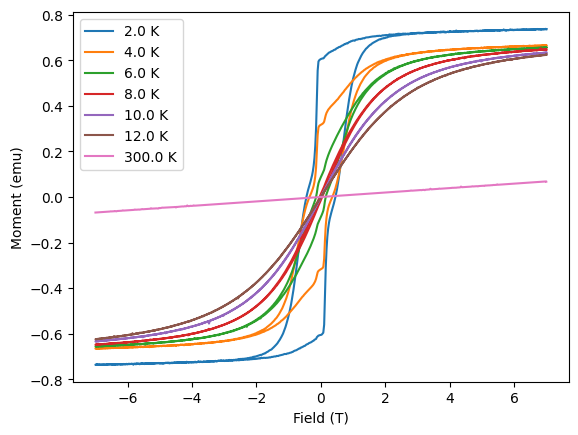

In [48]:
fig, ax = plot_mvsh(mvsh1)
plt.show()

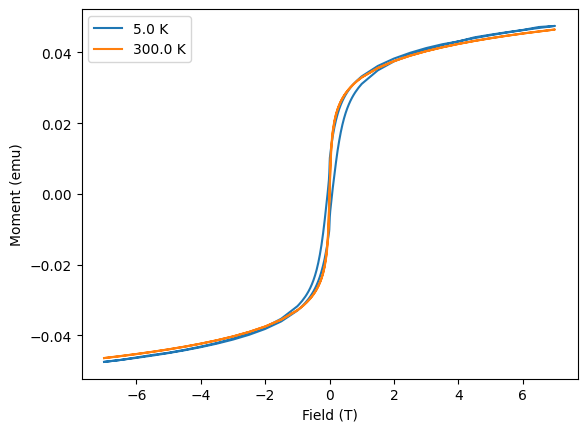

In [49]:
fig, ax = plot_mvsh(mvsh2)
plt.show()

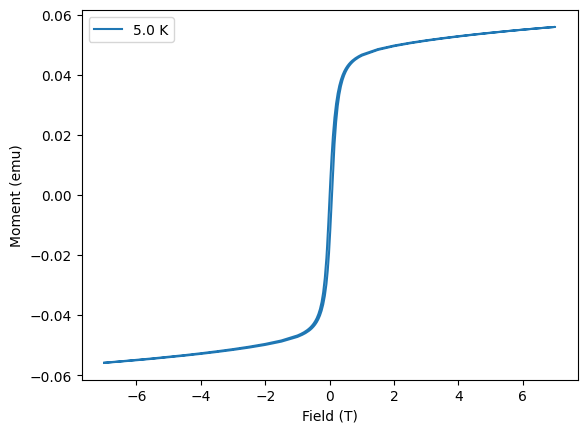

In [50]:
fig, ax = plot_mvsh(mvsh3)
plt.show()